C:\Users\User\AppData\Local\Temp\ipykernel_7756\582081220.py:39: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  event_df = pd.read_csv(event_path)
C:\Users\User\AppData\Local\Temp\ipykernel_7756\582081220.py:39: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  event_df = pd.read_csv(event_path)


Total events with frames: 47853
Total tracking frames between pass events: 172364

=== FILTERING RESULTS ===
Original segments: 6559
High pass segments (max z > 1.8m): 1107
Original tracking frames: 172364
Filtered tracking frames: 31755


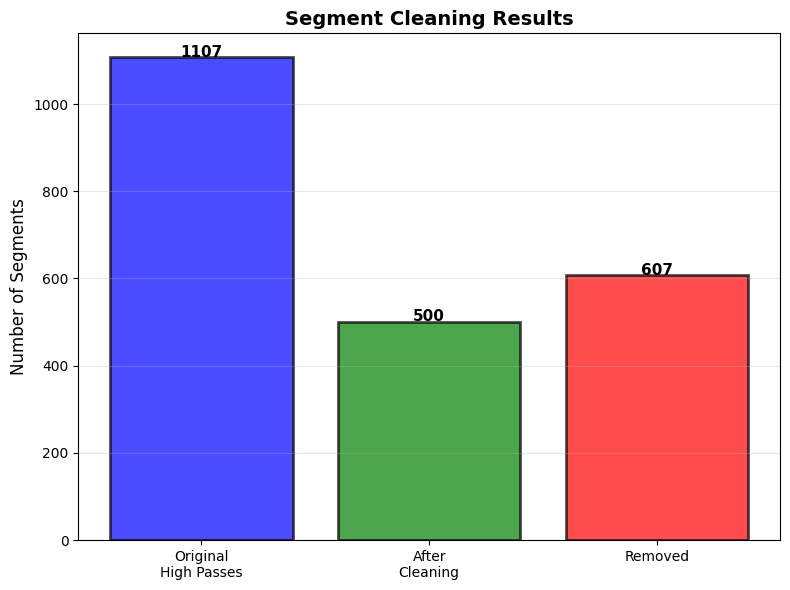

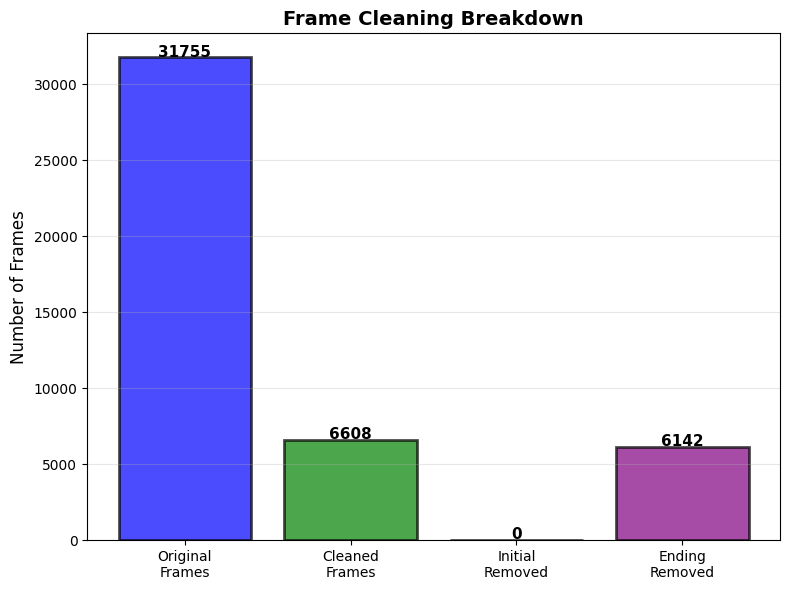

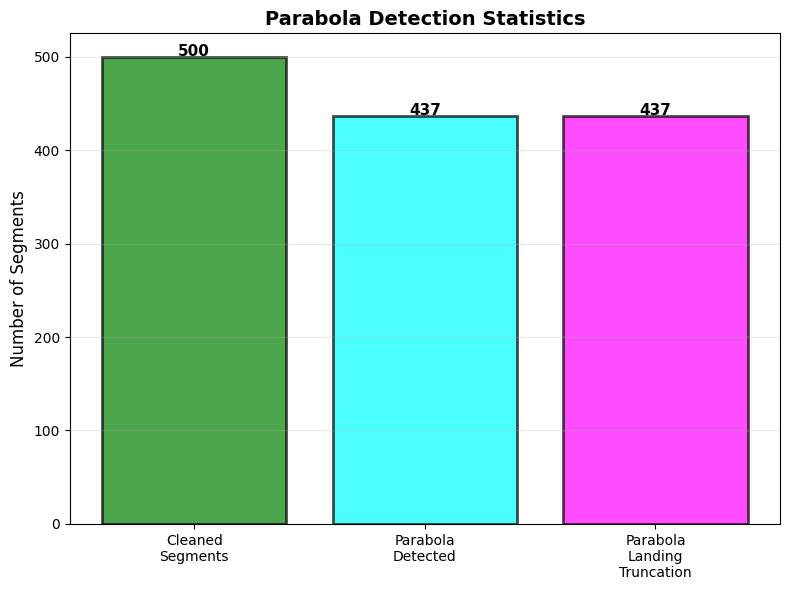

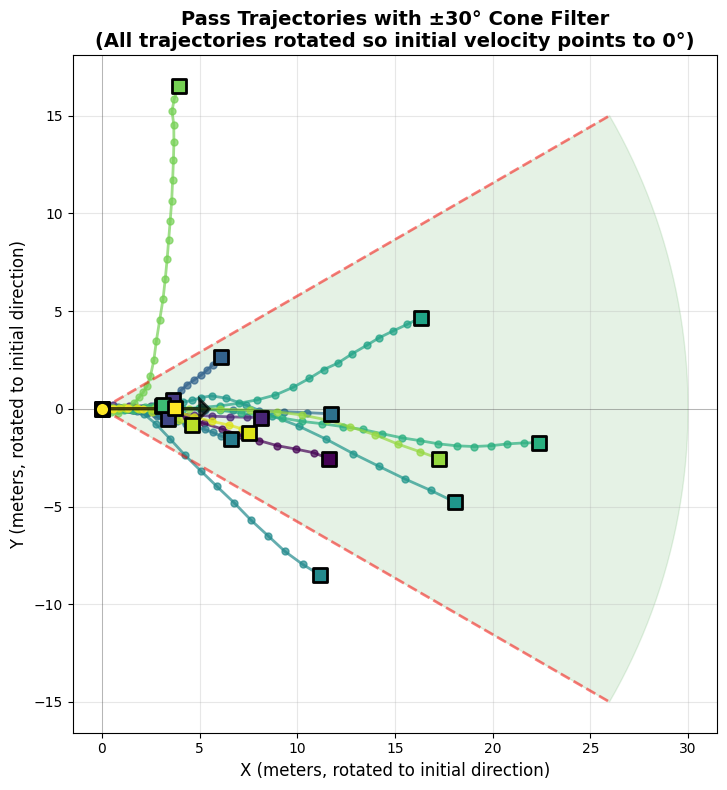

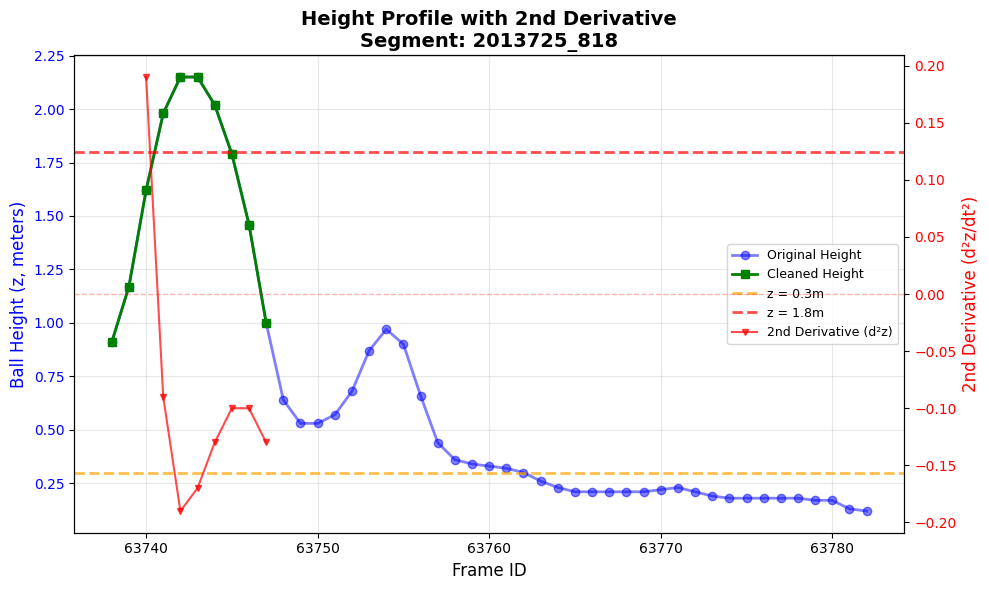

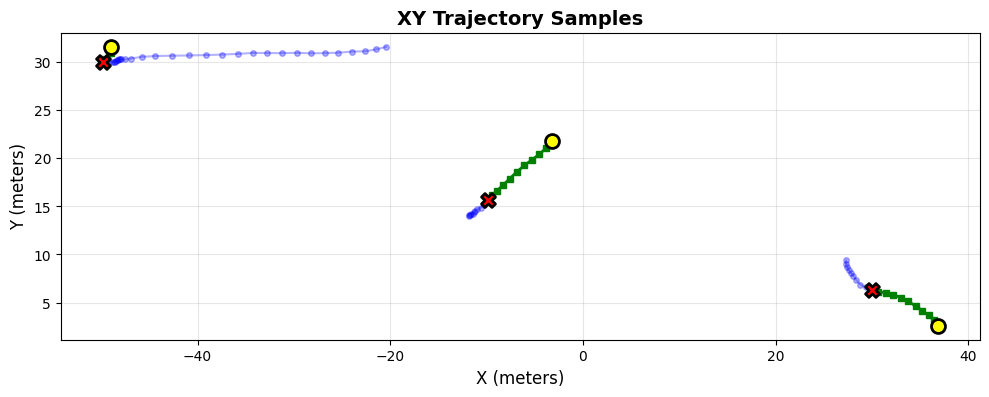

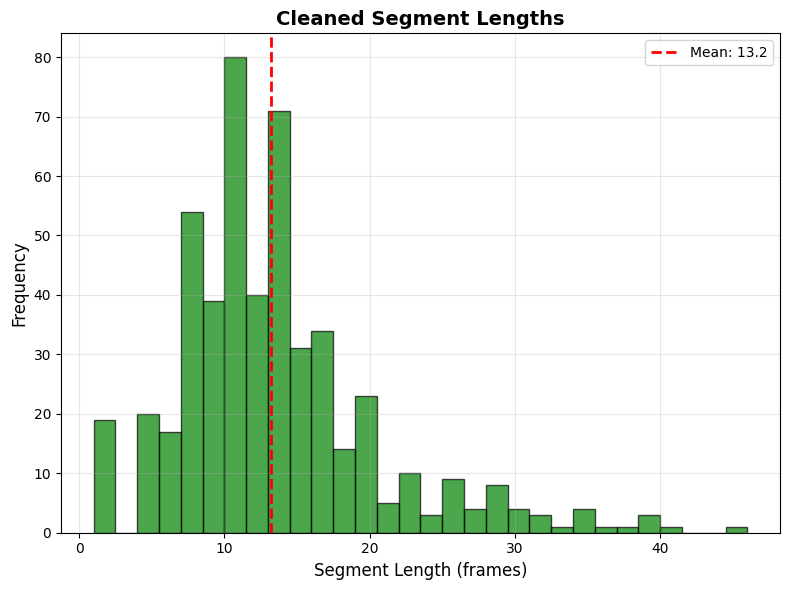


✓ All plots saved as separate images!
✓ Cleaned data has 6608 frames across 500 segments.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kloppy import skillcorner
# import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
pd.options.display.max_columns = None

# %%
match_ids = [
    1886347, 1899585, 1925299, 1953632, 1996435,
    2006229, 2011166, 2013725, 2015213, 2017461,
]

all_events = []
match_records = {}
all_tracking_segments = []

for match_id in match_ids:
    tracking_url = (
        f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/"
        f"data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"
    )
    meta_url = (
        f"https://raw.githubusercontent.com/SkillCorner/opendata/master/"
        f"data/matches/{match_id}/{match_id}_match.json"
    )

    dataset = skillcorner.load(
        meta_data=meta_url,
        raw_data=tracking_url,
        coordinates="skillcorner",
        sample_rate=1,
    )

    event_path = f"../opendata/data/matches/{match_id}/{match_id}_dynamic_events.csv"
    event_df = pd.read_csv(event_path)

    records_by_frame = {}
    frame_records = []
    for frame in dataset.records:
        records_by_frame[frame.frame_id] = frame
        coords = frame.ball_coordinates
        frame_records.append(
            {
                "frame_id": frame.frame_id,
                "ball_x": coords.x if coords is not None else np.nan,
                "ball_y": coords.y if coords is not None else np.nan,
                "ball_z": getattr(coords, "z", np.nan) if coords is not None else np.nan,
            }
        )

    match_records[match_id] = records_by_frame

    frames_df = (
        pd.DataFrame(frame_records)
        .sort_values("frame_id")
        .reset_index(drop=True)
    )

    _event_ordered = event_df.copy()
    _event_ordered["_event_idx"] = _event_ordered.index
    _event_sorted = _event_ordered.sort_values("frame_start").reset_index(drop=True)

    merged_df = pd.merge_asof(
        _event_sorted,
        frames_df,
        left_on="frame_start",
        right_on="frame_id",
        direction="nearest",
    )
    merged_df["frame_diff"] = (merged_df["frame_start"] - merged_df["frame_id"]).abs()

    events_with_frames = (
        merged_df.sort_values("_event_idx")
        .drop(columns="_event_idx")
        .reset_index(drop=True)
    )
    events_with_frames["match_id"] = match_id
    
    passes_this_match = events_with_frames[events_with_frames["pass_outcome"].notna()].copy()
    passes_this_match = passes_this_match.sort_values("frame_start").reset_index(drop=True)
    
    for i in range(len(passes_this_match) - 1):
        pass_end_frame = passes_this_match.iloc[i]["frame_start"]
        next_pass_start_frame = passes_this_match.iloc[i + 1]["frame_start"]
        
        if next_pass_start_frame - pass_end_frame > 50:
            continue
        
        segment_frames = frames_df[
            (frames_df["frame_id"] >= pass_end_frame) & 
            (frames_df["frame_id"] <= next_pass_start_frame)
        ].copy()
        
        if len(segment_frames) > 0:
            segment_frames["match_id"] = match_id
            segment_frames["pass_event_id"] = passes_this_match.iloc[i]["event_id"]
            segment_frames["next_event_id"] = passes_this_match.iloc[i + 1]["event_id"]
            segment_frames["segment_id"] = f"{match_id}_{i}"
            all_tracking_segments.append(segment_frames)
    
    all_events.append(events_with_frames)

events_with_frames = pd.concat(all_events, ignore_index=True)
tracking_df = pd.concat(all_tracking_segments, ignore_index=True)

print(f"Total events with frames: {len(events_with_frames)}")
print(f"Total tracking frames between pass events: {len(tracking_df)}")

# Filter for high passes
segment_max_z = tracking_df.groupby('segment_id')['ball_z'].max().reset_index()
segment_max_z.columns = ['segment_id', 'max_z']

high_segments = segment_max_z[segment_max_z['max_z'] > 1.8]['segment_id']
tracking_df_filtered = tracking_df[tracking_df['segment_id'].isin(high_segments)].copy()

print(f"\n=== FILTERING RESULTS ===")
print(f"Original segments: {tracking_df['segment_id'].nunique()}")
print(f"High pass segments (max z > 1.8m): {len(high_segments)}")
print(f"Original tracking frames: {len(tracking_df)}")
print(f"Filtered tracking frames: {len(tracking_df_filtered)}")

def clean_high_pass_segment(segment_df, direction_change_threshold=45, cone_angle=30, 
                            max_ending_height=1.8, max_start_height=3.0, 
                            max_frame_distance=2.0):
    segment_df = segment_df.sort_values('frame_id').reset_index(drop=True)
    segment_df = segment_df[segment_df['ball_z'].notna()].reset_index(drop=True)
    
    if len(segment_df) == 0:
        return None, False, "no_data"
    
    start_height = segment_df['ball_z'].iloc[0]
    if start_height > max_start_height:
        return None, False, "start_too_high"
    
    x = segment_df['ball_x'].values
    y = segment_df['ball_y'].values
    z = segment_df['ball_z'].values
    
    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    
    if np.any(distances > max_frame_distance):
        return None, False, "frame_gap_too_large"
    
    landing_idx = None
    reached_high = False
    parabola_detected = False
    
    if len(z) >= 5:
        dz_dt = np.diff(z)
        ddz = np.diff(dz_dt)
        
        for i in range(len(z)):
            if z[i] > 1.8:
                reached_high = True
                break
        
        if reached_high:
            search_start = min(len(ddz), np.argmax(z) + 2)
            
            for i in range(search_start, len(ddz) - 1):
                if ddz[i] < 0 and ddz[i + 1] > 0:
                    landing_idx = i + 2
                    parabola_detected = True
                    break
    
    end_idx = len(segment_df)
    
    if landing_idx is not None:
        end_idx = min(end_idx, landing_idx + 1)
    elif reached_high:
        for i, z_val in enumerate(z):
            if z_val > 1.8:
                reached_high = True
            elif reached_high and z_val < 0.3:
                end_idx = i + 1
                break
    
    segment_df = segment_df.iloc[:end_idx].reset_index(drop=True)
    
    if len(segment_df) < 3:
        return (segment_df if len(segment_df) > 0 else None), parabola_detected, "too_short"
    
    x = segment_df['ball_x'].values
    y = segment_df['ball_y'].values
    
    dx = np.diff(x)
    dy = np.diff(y)
    
    angles = np.arctan2(dy, dx) * 180 / np.pi
    angle_changes = np.diff(angles)
    
    angle_changes = np.where(angle_changes > 180, angle_changes - 360, angle_changes)
    angle_changes = np.where(angle_changes < -180, angle_changes + 360, angle_changes)
    
    angle_changes_abs = np.abs(angle_changes)
    
    check_start = min(3, len(angle_changes_abs))
    sudden_changes = np.where(angle_changes_abs[check_start:] > direction_change_threshold)[0]
    
    if len(sudden_changes) > 0:
        truncate_idx = sudden_changes[0] + check_start + 2
        segment_df = segment_df.iloc[:truncate_idx].reset_index(drop=True)
    
    if len(segment_df) < 3:
        return (segment_df if len(segment_df) > 0 else None), parabola_detected, "too_short"
    
    final_height = segment_df['ball_z'].iloc[-1]
    if final_height > max_ending_height:
        return None, parabola_detected, "end_too_high"
    
    return (segment_df if len(segment_df) > 0 else None), parabola_detected, "cleaned"

# Clean segments
cleaned_segments = []
cleaning_stats = {
    'original_segments': len(high_segments),
    'cleaned_segments': 0,
    'removed_segments': 0,
    'removed_by_start_height': 0,
    'removed_by_frame_gap': 0,
    'removed_by_cone_filter': 0,
    'removed_by_end_height': 0,
    'removed_too_short': 0,
    'initial_frames_removed': 0,
    'ending_frames_removed': 0,
    'direction_change_truncations': 0,
    'parabola_detected': 0,
    'parabola_landing_truncations': 0,
    'original_frames': len(tracking_df_filtered),
    'cleaned_frames': 0
}

for seg_id in high_segments:
    segment = tracking_df_filtered[tracking_df_filtered['segment_id'] == seg_id].copy()
    original_len = len(segment)
    
    cleaned, parabola_detected, filter_reason = clean_high_pass_segment(
        segment, 
        direction_change_threshold=45, 
        cone_angle=30,
        max_start_height=3.0,
        max_frame_distance=2.0
    )
    
    if cleaned is not None and len(cleaned) > 0:
        cleaned_segments.append(cleaned)
        cleaning_stats['cleaned_segments'] += 1
        cleaning_stats['cleaned_frames'] += len(cleaned)
        
        if parabola_detected:
            cleaning_stats['parabola_detected'] += 1
            if len(cleaned) < original_len:
                cleaning_stats['parabola_landing_truncations'] += 1
        
        frames_removed = original_len - len(cleaned)
        if frames_removed > 0:
            if cleaned['frame_id'].iloc[0] > segment['frame_id'].iloc[0]:
                initial_removed = len(segment[segment['frame_id'] < cleaned['frame_id'].iloc[0]])
                cleaning_stats['initial_frames_removed'] += initial_removed
            if cleaned['frame_id'].iloc[-1] < segment['frame_id'].iloc[-1]:
                ending_removed = len(segment[segment['frame_id'] > cleaned['frame_id'].iloc[-1]])
                cleaning_stats['ending_frames_removed'] += ending_removed
                cleaning_stats['direction_change_truncations'] += 1
    else:
        cleaning_stats['removed_segments'] += 1
        if filter_reason == "start_too_high":
            cleaning_stats['removed_by_start_height'] += 1
        elif filter_reason == "frame_gap_too_large":
            cleaning_stats['removed_by_frame_gap'] += 1
        elif filter_reason == "cone_filter":
            cleaning_stats['removed_by_cone_filter'] += 1
        elif filter_reason == "end_too_high":
            cleaning_stats['removed_by_end_height'] += 1
        elif filter_reason == "too_short":
            cleaning_stats['removed_too_short'] += 1

tracking_df_cleaned = pd.concat(cleaned_segments, ignore_index=True) if cleaned_segments else pd.DataFrame()

# ============================================================================
# PLOT 1: Segment Count Comparison
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Original\nHigh Passes', 'After\nCleaning', 'Removed']
values = [cleaning_stats['original_segments'], 
          cleaning_stats['cleaned_segments'],
          cleaning_stats['removed_segments']]
colors_bar = ['blue', 'green', 'red']
bars = ax.bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Segments', fontsize=12)
ax.set_title('Segment Cleaning Results', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 2, str(val), 
            ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('plot1_segment_count.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 2: Frame Removal Breakdown
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))
frame_categories = ['Original\nFrames', 'Cleaned\nFrames', 'Initial\nRemoved', 'Ending\nRemoved']
frame_values = [cleaning_stats['original_frames'],
                cleaning_stats['cleaned_frames'],
                cleaning_stats['initial_frames_removed'],
                cleaning_stats['ending_frames_removed']]
colors_frame = ['blue', 'green', 'orange', 'purple']
bars = ax.bar(frame_categories, frame_values, color=colors_frame, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Frames', fontsize=12)
ax.set_title('Frame Cleaning Breakdown', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, frame_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 50, str(val), 
            ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('plot2_frame_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 3: Parabola Detection Statistics
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))
parabola_categories = ['Cleaned\nSegments', 'Parabola\nDetected', 'Parabola\nLanding\nTruncation']
parabola_values = [
    cleaning_stats['cleaned_segments'],
    cleaning_stats['parabola_detected'],
    cleaning_stats['parabola_landing_truncations']
]
colors_parabola = ['green', 'cyan', 'magenta']
bars = ax.bar(parabola_categories, parabola_values, color=colors_parabola, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Segments', fontsize=12)
ax.set_title('Parabola Detection Statistics', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, parabola_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1, str(val), 
            ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('plot3_parabola_stats.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 4: Cone Visualization (ROTATED to 0 degrees)
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 8))
if len(cleaned_segments) > 0:
    n_samples = min(20, len(cleaned_segments))
    sample_indices = np.random.choice(len(cleaned_segments), n_samples, replace=False)
    
    colors_samples = plt.cm.viridis(np.linspace(0, 1, n_samples))
    
    for idx, seg_idx in enumerate(sample_indices):
        seg = cleaned_segments[seg_idx]
        seg = seg.sort_values('frame_id').reset_index(drop=True)
        
        x = seg['ball_x'].values
        y = seg['ball_y'].values
        
        # Shift to start at origin
        x_shifted = x - x[0]
        y_shifted = y - y[0]
        
        # Calculate initial direction (using first few frames)
        n_init = min(3, len(x) - 1)
        init_dx = x[n_init] - x[0]
        init_dy = y[n_init] - y[0]
        initial_angle = np.arctan2(init_dy, init_dx)
        
        # Rotate so initial velocity points to 0 degrees (positive x-axis)
        cos_theta = np.cos(-initial_angle)
        sin_theta = np.sin(-initial_angle)
        
        x_rotated = x_shifted * cos_theta - y_shifted * sin_theta
        y_rotated = x_shifted * sin_theta + y_shifted * cos_theta
        
        ax.plot(x_rotated, y_rotated, 'o-', color=colors_samples[idx], 
                linewidth=2, markersize=5, alpha=0.7, label=f'Pass {idx+1}')
        
        ax.scatter(0, 0, color=colors_samples[idx], s=100, marker='o', 
                  edgecolors='black', linewidths=2, zorder=5)
        
        ax.scatter(x_rotated[-1], y_rotated[-1], color=colors_samples[idx], 
                  s=100, marker='s', edgecolors='black', linewidths=2, zorder=5)
    
    # Draw cone at 0 degrees
    cone_angle = 30
    max_dist = 30
    
    # Initial velocity arrow pointing to 0 degrees
    ax.arrow(0, 0, 5, 0, head_width=1, head_length=0.5, fc='black', 
            ec='black', linewidth=2, alpha=0.7, zorder=3, label='Initial Velocity')
    
    # Cone boundaries
    angle1 = np.radians(cone_angle)
    angle2 = np.radians(-cone_angle)
    
    cone_x1 = [0, max_dist * np.cos(angle1)]
    cone_y1 = [0, max_dist * np.sin(angle1)]
    cone_x2 = [0, max_dist * np.cos(angle2)]
    cone_y2 = [0, max_dist * np.sin(angle2)]
    
    ax.plot(cone_x1, cone_y1, 'r--', linewidth=2, alpha=0.5, label='±30° Cone')
    ax.plot(cone_x2, cone_y2, 'r--', linewidth=2, alpha=0.5)
    
    # Fill cone
    theta = np.linspace(-cone_angle, cone_angle, 50)
    theta_rad = np.radians(theta)
    r = max_dist
    x_cone = r * np.cos(theta_rad)
    y_cone = r * np.sin(theta_rad)
    x_cone = np.concatenate([[0], x_cone, [0]])
    y_cone = np.concatenate([[0], y_cone, [0]])
    ax.fill(x_cone, y_cone, color='green', alpha=0.1)
    
    ax.set_xlabel('X (meters, rotated to initial direction)', fontsize=12)
    ax.set_ylabel('Y (meters, rotated to initial direction)', fontsize=12)
    ax.set_title('Pass Trajectories with ±30° Cone Filter\n(All trajectories rotated so initial velocity points to 0°)', 
                fontsize=14, fontweight='bold')
    # ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
    
plt.tight_layout()
plt.savefig('plot4_cone_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 5: Height Profile with 2nd Derivative
# ============================================================================
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

if len(cleaned_segments) > 0:
    sample_seg_id = np.random.choice([s['segment_id'].iloc[0] for s in cleaned_segments])
    original_seg = tracking_df_filtered[tracking_df_filtered['segment_id'] == sample_seg_id].copy()
    original_seg = original_seg.sort_values('frame_id').reset_index(drop=True)
    
    cleaned_seg = tracking_df_cleaned[tracking_df_cleaned['segment_id'] == sample_seg_id]
    
    if len(cleaned_seg) > 0:
        cleaned_seg = cleaned_seg.sort_values('frame_id').reset_index(drop=True)
        
        ax1.plot(original_seg['frame_id'], original_seg['ball_z'], 
                'o-', color='blue', alpha=0.5, linewidth=2, markersize=6, label='Original Height')
        
        ax1.plot(cleaned_seg['frame_id'], cleaned_seg['ball_z'], 
                's-', color='green', linewidth=2, markersize=6, label='Cleaned Height')
        
        z = cleaned_seg['ball_z'].values
        if len(z) >= 5:
            dz = np.diff(z)
            ddz = np.diff(dz)
            frame_ids_ddz = cleaned_seg['frame_id'].values[2:]
            
            ax2.plot(frame_ids_ddz, ddz, 'v-', color='red', linewidth=1.5, 
                    markersize=4, alpha=0.7, label='2nd Derivative (d²z)')
            ax2.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.3)
            
            for i in range(len(ddz) - 1):
                if ddz[i] < 0 and ddz[i + 1] > 0:
                    landing_frame = frame_ids_ddz[i + 1]
                    ax1.axvline(landing_frame, color='magenta', linestyle=':', 
                               linewidth=2.5, alpha=0.8, label='Landing (d²z sign change)')
                    break
        
        ax1.axhline(0.3, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='z = 0.3m')
        ax1.axhline(1.8, color='red', linestyle='--', linewidth=2, alpha=0.7, label='z = 1.8m')
        
        ax1.set_xlabel('Frame ID', fontsize=12)
        ax1.set_ylabel('Ball Height (z, meters)', fontsize=12, color='blue')
        ax2.set_ylabel('2nd Derivative (d²z/dt²)', fontsize=12, color='red')
        ax1.set_title(f'Height Profile with 2nd Derivative\nSegment: {sample_seg_id}', 
                     fontsize=14, fontweight='bold')
        
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot5_height_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 6: XY Trajectory Comparison
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 8))
if len(cleaned_segments) > 0:
    for seg_id in [s['segment_id'].iloc[0] for s in cleaned_segments[:3]]:
        original_seg = tracking_df_filtered[tracking_df_filtered['segment_id'] == seg_id].copy()
        original_seg = original_seg.sort_values('frame_id').reset_index(drop=True)
        cleaned_seg = tracking_df_cleaned[tracking_df_cleaned['segment_id'] == seg_id]
        
        if len(cleaned_seg) > 0 and len(original_seg) >= len(cleaned_seg):
            cleaned_seg = cleaned_seg.sort_values('frame_id').reset_index(drop=True)
            
            ax.plot(original_seg['ball_x'], original_seg['ball_y'], 
                    'o-', color='blue', alpha=0.3, linewidth=1.5, markersize=4)
            
            ax.plot(cleaned_seg['ball_x'], cleaned_seg['ball_y'], 
                    's-', color='green', linewidth=2, markersize=5)
            
            ax.scatter(cleaned_seg['ball_x'].iloc[0], cleaned_seg['ball_y'].iloc[0],
                      color='yellow', s=100, marker='o', edgecolors='black', 
                      linewidths=2, zorder=5)
            
            ax.scatter(cleaned_seg['ball_x'].iloc[-1], cleaned_seg['ball_y'].iloc[-1],
                      color='red', s=100, marker='X', edgecolors='black', 
                      linewidths=2, zorder=5)
    
    ax.set_xlabel('X (meters)', fontsize=12)
    ax.set_ylabel('Y (meters)', fontsize=12)
    ax.set_title('XY Trajectory Samples', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('plot6_xy_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PLOT 7: Distribution of Segment Lengths
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))
if len(tracking_df_cleaned) > 0:
    segment_lengths_cleaned = tracking_df_cleaned.groupby('segment_id').size()
    ax.hist(segment_lengths_cleaned, bins=30, edgecolor='black', alpha=0.7, color='green')
    ax.axvline(segment_lengths_cleaned.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {segment_lengths_cleaned.mean():.1f}')
    ax.set_xlabel('Segment Length (frames)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Cleaned Segment Lengths', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot7_segment_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ All plots saved as separate images!")
print(f"✓ Cleaned data has {len(tracking_df_cleaned)} frames across {tracking_df_cleaned['segment_id'].nunique()} segments.")

segment_frame_counts = tracking_df_cleaned.groupby('segment_id')['frame_id'].nunique()
valid_segments = segment_frame_counts[segment_frame_counts >= 10].index
tracking_df_cleaned = tracking_df_cleaned[tracking_df_cleaned['segment_id'].isin(valid_segments)].reset_index(drop=True)

In [2]:
def normalize_and_rotate_coordinates(segment_df, n_init_frames=3):
    """
    Normalize coordinates to origin (0,0,z) and rotate XY plane so initial 
    velocity vector points to 0 degrees (positive X-axis).
    
    Parameters:
    -----------
    segment_df : pd.DataFrame
        DataFrame containing 'ball_x', 'ball_y', 'ball_z' columns
    n_init_frames : int
        Number of initial frames to use for calculating initial velocity direction
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional columns:
        - ball_x_norm: normalized and rotated X coordinate
        - ball_y_norm: normalized and rotated Y coordinate  
        - ball_z_norm: unchanged Z coordinate (same as ball_z)
        - rotation_angle: the angle (in radians) used for rotation
    """
    segment_df = segment_df.copy()
    
    # Extract coordinates
    x = segment_df['ball_x'].values
    y = segment_df['ball_y'].values
    z = segment_df['ball_z'].values
    
    # Get initial position
    x0, y0, z0 = x[0], y[0], z[0]
    
    # Calculate initial velocity direction (average over first n frames)
    n_init = min(n_init_frames, len(x) - 1)
    initial_dx = x[n_init] - x[0]
    initial_dy = y[n_init] - y[0]
    
    # Calculate initial velocity angle
    initial_angle = np.arctan2(initial_dy, initial_dx)
    
    # Step 1: Translate to origin
    x_translated = x - x0
    y_translated = y - y0
    z_translated = z  # Z remains unchanged in absolute terms
    
    # Step 2: Rotate XY plane so initial velocity points to 0° (positive X-axis)
    # Rotation matrix for counterclockwise rotation by -initial_angle
    cos_theta = np.cos(-initial_angle)
    sin_theta = np.sin(-initial_angle)
    
    x_norm = x_translated * cos_theta - y_translated * sin_theta
    y_norm = x_translated * sin_theta + y_translated * cos_theta
    z_norm = z_translated
    
    # Add normalized coordinates to dataframe
    segment_df['ball_x_norm'] = x_norm
    segment_df['ball_y_norm'] = y_norm
    segment_df['ball_z_norm'] = z_norm
    segment_df['rotation_angle'] = initial_angle
    
    return segment_df


def normalize_all_segments(tracking_df, segment_id_col='segment_id'):
    """
    Apply normalization and rotation to all segments in a tracking dataframe.
    
    Parameters:
    -----------
    tracking_df : pd.DataFrame
        DataFrame containing tracking data with segment IDs
    segment_id_col : str
        Name of the column containing segment IDs
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with normalized coordinates for all segments
    """
    normalized_segments = []
    
    for seg_id in tracking_df[segment_id_col].unique():
        segment = tracking_df[tracking_df[segment_id_col] == seg_id].copy()
        segment = segment.sort_values('frame_id').reset_index(drop=True)
        
        normalized_segment = normalize_and_rotate_coordinates(segment)
        normalized_segments.append(normalized_segment)
    
    return pd.concat(normalized_segments, ignore_index=True)


# Verify normalization for a sample segment
def verify_normalization(segment_df):
    """
    Print verification info for normalized coordinates.
    """
    print("=== Normalization Verification ===")
    print(f"\nOriginal coordinates:")
    print(f"  Start: ({segment_df['ball_x'].iloc[0]:.2f}, {segment_df['ball_y'].iloc[0]:.2f}, {segment_df['ball_z'].iloc[0]:.2f})")
    print(f"  End:   ({segment_df['ball_x'].iloc[-1]:.2f}, {segment_df['ball_y'].iloc[-1]:.2f}, {segment_df['ball_z'].iloc[-1]:.2f})")
    
    print(f"\nNormalized coordinates:")
    print(f"  Start: ({segment_df['ball_x_norm'].iloc[0]:.2f}, {segment_df['ball_y_norm'].iloc[0]:.2f}, {segment_df['ball_z_norm'].iloc[0]:.2f})")
    print(f"  End:   ({segment_df['ball_x_norm'].iloc[-1]:.2f}, {segment_df['ball_y_norm'].iloc[-1]:.2f}, {segment_df['ball_z_norm'].iloc[-1]:.2f})")
    
    # Calculate initial velocity direction in normalized space
    n_init = min(3, len(segment_df) - 1)
    dx_norm = segment_df['ball_x_norm'].iloc[n_init] - segment_df['ball_x_norm'].iloc[0]
    dy_norm = segment_df['ball_y_norm'].iloc[n_init] - segment_df['ball_y_norm'].iloc[0]
    angle_norm = np.arctan2(dy_norm, dx_norm) * 180 / np.pi
    
    print(f"\nInitial velocity angle in normalized space: {angle_norm:.2f}° (should be ~0°)")
    print(f"Rotation angle applied: {segment_df['rotation_angle'].iloc[0] * 180 / np.pi:.2f}°")

tracking_df_normalized = normalize_all_segments(tracking_df_cleaned)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from joblib import Parallel, delayed
import multiprocessing
import math

# =============================================================================
# CONFIGURATION
# =============================================================================
N_INITIAL_FRAMES = 5
N_FOLDS = 5
RANDOM_STATE = 42
M_TO_FT = 3.28084

# =============================================================================
# PART 1: XGBOOST TRAINING (from Document 1)
# =============================================================================

def compute_velocity(coords, frame_ids, fps=10):
    """Compute velocity from coordinate sequence."""
    if len(coords) < 2:
        return np.array([0.0, 0.0, 0.0])
    
    dx = np.diff(coords[:, 0])
    dy = np.diff(coords[:, 1])
    dz = np.diff(coords[:, 2])
    dt = np.diff(frame_ids) / fps
    dt = np.where(dt == 0, 1e-6, dt)
    
    vx = dx / dt
    vy = dy / dt
    vz = dz / dt
    
    return np.array([np.mean(vx), np.mean(vy), np.mean(vz)])


def transform_to_normalized_coordinates(x, y, z, vx, vy):
    """Transform coordinates to normalized frame."""
    x_norm = x - x[0]
    y_norm = y - y[0]
    z_norm = z - z[0]
    
    initial_velocity_angle = np.arctan2(vy, vx)
    cos_theta = np.cos(-initial_velocity_angle)
    sin_theta = np.sin(-initial_velocity_angle)
    
    x_rot = x_norm * cos_theta - y_norm * sin_theta
    y_rot = x_norm * sin_theta + y_norm * cos_theta
    
    return x_rot, y_rot, z_norm, initial_velocity_angle


def create_training_samples(tracking_df, n_initial_frames=5):
    """Create training samples from tracking data."""
    samples = []
    
    for segment_id in tracking_df['segment_id'].unique():
        segment = tracking_df[tracking_df['segment_id'] == segment_id].copy()
        segment = segment.sort_values('frame_id').reset_index(drop=True)
        
        if len(segment) < n_initial_frames + 1:
            continue
        
        segment = segment[
            segment['ball_x'].notna() & 
            segment['ball_y'].notna() & 
            segment['ball_z'].notna()
        ]
        
        if len(segment) < n_initial_frames + 1:
            continue
        
        initial_segment = segment.iloc[:n_initial_frames]
        x_coords = initial_segment['ball_x'].values
        y_coords = initial_segment['ball_y'].values
        z_coords = initial_segment['ball_z'].values
        frame_ids = initial_segment['frame_id'].values
        
        coords_3d = np.column_stack([x_coords, y_coords, z_coords])
        velocity = compute_velocity(coords_3d, frame_ids)
        
        vx_initial, vy_initial, vz_initial = velocity
        velocity_magnitude = np.sqrt(vx_initial**2 + vy_initial**2)
        
        if velocity_magnitude < 0.1:
            continue
        
        for target_idx in range(n_initial_frames, len(segment)):
            target_row = segment.iloc[target_idx]
            
            all_x = np.append(x_coords, target_row['ball_x'])
            all_y = np.append(y_coords, target_row['ball_y'])
            all_z = np.append(z_coords, target_row['ball_z'])
            
            x_norm, y_norm, _, angle = transform_to_normalized_coordinates(
                all_x, all_y, all_z, vx_initial, vy_initial
            )
            
            target_x_norm = x_norm[-1]
            target_y_norm = y_norm[-1]
            target_z = all_z[-1]
            
            time_to_target = (target_row['frame_id'] - frame_ids[0]) / 10.0
            
            vx_norm = velocity_magnitude
            vy_norm = 0.0
            vz_norm = vz_initial
            
            sample = {
                'segment_id': segment_id,
                'target_frame_idx': target_idx,
                'x0': 0.0,
                'y0': 0.0,
                'z0': z_coords[0],
                'vx0': vx_norm,
                'vy0': vy_norm,
                'vz0': vz_norm,
                'v_magnitude': velocity_magnitude,
                'time_to_target': time_to_target,
                'original_x0': x_coords[0],
                'original_y0': y_coords[0],
                'original_z0': z_coords[0],
                'rotation_angle': angle,
                'target_x_norm': target_x_norm,
                'target_y_norm': target_y_norm,
                'target_z_norm': target_z,
                'num_frames': target_idx - 0,
            }
            
            samples.append(sample)
    
    return pd.DataFrame(samples)


def train_xgboost_models(training_data):
    """Train XGBoost models with cross-validation."""
    feature_cols = ['vx0', 'vy0', 'vz0', 'v_magnitude', 'time_to_target']
    
    X = training_data[feature_cols].values
    y_x = training_data['target_x_norm'].values
    y_y = training_data['target_y_norm'].values
    
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    models_x = []
    models_y = []
    
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    print("\nTraining XGBoost Models...")
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_x_train, y_x_val = y_x[train_idx], y_x[val_idx]
        y_y_train, y_y_val = y_y[train_idx], y_y[val_idx]
        
        model_x = xgb.XGBRegressor(**params)
        model_x.fit(X_train, y_x_train, eval_set=[(X_val, y_x_val)], verbose=False)
        models_x.append(model_x)
        
        model_y = xgb.XGBRegressor(**params)
        model_y.fit(X_train, y_y_train, eval_set=[(X_val, y_y_val)], verbose=False)
        models_y.append(model_y)
        
        print(f"Fold {fold_idx + 1}/{N_FOLDS} complete")
    
    return models_x, models_y, feature_cols


# =============================================================================
# PART 2: PHYSICS SIMULATION (from Document 2)
# =============================================================================

class SoccerPhysics:
    """Physics engine for soccer ball trajectory simulation."""
    def __init__(self):
        self.mass_oz = 15.0
        self.circumference_in = 27.0
        self.g = 32.174  # ft/s^2
        
        self.Temp_F = 78
        self.elev_ft = 0
        self.relative_humidity = 50
        self.barometric_pressure = 29.92
        
        # Calculate air density
        self.Temp_C = (5/9) * (self.Temp_F - 32)
        beta = 0.0001217
        SVP = 4.5841 * math.exp((18.687 - self.Temp_C / 234.5) * self.Temp_C / (257.14 + self.Temp_C))
        barometric_pressure_mmHg = self.barometric_pressure * 1000 / 39.37
        rho_kg_m3 = 1.2929 * (273 / (self.Temp_C + 273) * (barometric_pressure_mmHg * math.exp(-beta * self.elev_ft) - 0.3783 * self.relative_humidity * SVP / 100) / 760)
        self.rho_lb_ft3 = rho_kg_m3 * 0.06261
        
        self.base_c0 = 0.07182 * self.rho_lb_ft3 * (5.125 / self.mass_oz) * (self.circumference_in / 9.125)**2

    def get_derivatives(self, t, state, drag_mult, spins):
        """Calculate derivatives for RK4 integration."""
        x, y, z, vx, vy, vz = state
        backspin, sidespin = spins
        
        v = math.sqrt(vx*vx + vy*vy + vz*vz)
        if v == 0:
            return np.array([vx, vy, vz, 0, 0, 0])
        
        omega_side = sidespin * (2 * math.pi) / 60
        omega_back = backspin * (2 * math.pi) / 60
        
        wx = -omega_back
        wy = 0
        wz = omega_side
        omega = math.sqrt(wx*wx + wy*wy + wz*wz)
        
        if omega == 0:
            S = 0
            Cl = 0
            Cd = 0.4105 * drag_mult
        else:
            romega = (self.circumference_in / 2 / math.pi) * omega / 12
            tau = 25
            S = (romega / v) * math.exp(-t / (tau * 146.7 / v))
            Cd = (0.4105 * (1 + 0.2017 * S * S)) * drag_mult
            Cl = 1 / (2.32 + 0.4 / S)
        
        const = self.base_c0 * (Cl / omega) * v if omega > 0 else 0
        
        if omega > 0:
            aMagx = const * (wy*vz - wz*vy)
            aMagy = const * (wz*vx - wx*vz)
            aMagz = const * (wx*vy - wy*vx)
        else:
            aMagx, aMagy, aMagz = 0, 0, 0
        
        drag_const = -self.base_c0 * Cd * v
        ax = drag_const * vx + aMagx
        ay = drag_const * vy + aMagy
        az = drag_const * vz + aMagz - self.g
        
        return np.array([vx, vy, vz, ax, ay, az])

    def simulate(self, initial_state, params, times):
        """Run RK4 simulation."""
        drag_mult, sidespin, backspin = params
        state = np.array(initial_state, dtype=float)
        
        dt = 0.01
        max_t = times[-1] + dt
        n_steps = int(max_t / dt) + 5
        
        traj_t = np.zeros(n_steps)
        traj_pos = np.zeros((n_steps, 3))
        traj_t[0] = 0.0
        traj_pos[0] = state[:3]
        
        current_t = 0.0
        step_idx = 0
        
        while current_t < max_t and step_idx < n_steps - 1:
            k1 = self.get_derivatives(current_t, state, drag_mult, [backspin, sidespin])
            k2 = self.get_derivatives(current_t + dt/2, state + k1*dt/2, drag_mult, [backspin, sidespin])
            k3 = self.get_derivatives(current_t + dt/2, state + k2*dt/2, drag_mult, [backspin, sidespin])
            k4 = self.get_derivatives(current_t + dt, state + k3*dt, drag_mult, [backspin, sidespin])
            
            state = state + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
            current_t += dt
            step_idx += 1
            
            traj_t[step_idx] = current_t
            traj_pos[step_idx] = state[:3]
            
            if state[2] < 0:
                break
        
        traj_t = traj_t[:step_idx+1]
        traj_pos = traj_pos[:step_idx+1]
        
        try:
            interp_x = interp1d(traj_t, traj_pos[:, 0], kind='cubic', fill_value="extrapolate")
            interp_y = interp1d(traj_t, traj_pos[:, 1], kind='cubic', fill_value="extrapolate")
            interp_z = interp1d(traj_t, traj_pos[:, 2], kind='cubic', fill_value="extrapolate")
            
            sim_pos = np.column_stack((interp_x(times), interp_y(times), interp_z(times)))
            return sim_pos
        except:
            return np.zeros((len(times), 3))


# =============================================================================
# PART 3: HYBRID PREDICTION PIPELINE WITH SHARED DRAG
# =============================================================================

def derive_initial_conditions_xgb(segment, models_x, models_y, feature_cols, n_initial=5):
    """Use XGBoost to predict trajectory and derive initial velocities."""
    segment = segment.sort_values('frame_id').reset_index(drop=True)
    
    if len(segment) < n_initial:
        return None
    
    initial_segment = segment.iloc[:n_initial]
    x_coords = initial_segment['ball_x'].values
    y_coords = initial_segment['ball_y'].values
    z_coords = initial_segment['ball_z'].values
    frame_ids = initial_segment['frame_id'].values
    
    coords_3d = np.column_stack([x_coords, y_coords, z_coords])
    velocity = compute_velocity(coords_3d, frame_ids)
    vx_initial, vy_initial, vz_initial = velocity
    velocity_magnitude = np.sqrt(vx_initial**2 + vy_initial**2)
    
    if velocity_magnitude < 0.1:
        return None
    
    all_x = x_coords
    all_y = y_coords
    all_z = z_coords
    
    x_norm, y_norm, z_norm, angle = transform_to_normalized_coordinates(
        all_x, all_y, all_z, vx_initial, vy_initial
    )
    
    total_time = (segment['frame_id'].iloc[-1] - frame_ids[0]) / 10.0
    num_frames = len(segment)
    
    features = np.array([[
        velocity_magnitude,
        0.0,
        vz_initial,
        velocity_magnitude,
        total_time
    ]])
    
    pred_x = np.mean([model.predict(features)[0] for model in models_x])
    pred_y = np.mean([model.predict(features)[0] for model in models_y])
    
    vx_xgb = pred_x / total_time if total_time > 0 else velocity_magnitude
    vy_xgb = pred_y / total_time if total_time > 0 else 0.0
    
    z_initial = segment['ball_z'].iloc[0]
    z_final = segment['ball_z'].iloc[-1]
    
    g_m = 9.81
    vz_derived = (z_final - z_initial + 0.5 * g_m * total_time**2) / total_time if total_time > 0 else vz_initial
    
    return {
        'segment_id': segment['segment_id'].iloc[0],
        'x0': x_coords[0],
        'y0': y_coords[0],
        'z0': z_coords[0],
        'vx_xgb': vx_xgb,
        'vy_xgb': vy_xgb,
        'vz_derived': vz_derived,
        'vx_direct': vx_initial,
        'vy_direct': vy_initial,
        'vz_direct': vz_initial,
        'total_time': total_time,
        'num_frames': num_frames,
        'rotation_angle': angle,
        'segment_data': segment
    }


def prepare_segment_data(init_cond):
    """Prepare segment data for optimization."""
    if init_cond is None:
        return None
    
    segment = init_cond['segment_data']
    coords = segment[['ball_x', 'ball_y', 'ball_z']].values
    
    x_norm, y_norm, z_norm, _ = transform_to_normalized_coordinates(
        coords[:, 0], coords[:, 1], coords[:, 2],
        init_cond['vx_direct'], init_cond['vy_direct']
    )
    
    real_pos_m = np.column_stack([x_norm, y_norm, coords[:, 2]])
    real_pos_ft = real_pos_m * M_TO_FT
    real_pos_mapped = np.column_stack([real_pos_ft[:, 1], real_pos_ft[:, 0], real_pos_ft[:, 2]])
    
    times = np.arange(len(segment)) * 0.1
    
    vx_ft = init_cond['vx_xgb'] * M_TO_FT
    vy_ft = init_cond['vy_xgb'] * M_TO_FT
    vz_ft = init_cond['vz_derived'] * M_TO_FT
    
    initial_state = [
        real_pos_mapped[0, 0],
        real_pos_mapped[0, 1],
        real_pos_mapped[0, 2],
        vy_ft,
        vx_ft,
        vz_ft
    ]
    
    return {
        'segment_id': init_cond['segment_id'],
        'real_pos': real_pos_mapped,
        'times': times,
        'initial_state': initial_state,
        'vx_xgb': init_cond['vx_xgb'],
        'vy_xgb': init_cond['vy_xgb'],
        'vz_derived': init_cond['vz_derived']
    }


def optimize_spins_fixed_drag(segment_data, drag_mult, physics_engine):
    """Optimize spin rates for a single segment with fixed drag."""
    def objective(spins):
        params = [drag_mult, spins[0], spins[1]]  # drag is fixed, optimize spins
        sim_pos = physics_engine.simulate(segment_data['initial_state'], params, segment_data['times'])
        diff = sim_pos - segment_data['real_pos']
        weights = np.array([1.0, 1.0, 2.0])
        weighted_sq_error = (diff**2) * weights
        return np.mean(weighted_sq_error)
    
    x0 = [0.0, 100.0]  # [sidespin, backspin]
    bnds = ((-1500, 1500), (-1000, 3000))
    
    try:
        res = minimize(objective, x0, method='L-BFGS-B', bounds=bnds, options={'maxiter': 50})
        final_path = physics_engine.simulate(
            segment_data['initial_state'], 
            [drag_mult, res.x[0], res.x[1]], 
            segment_data['times']
        )
        
        return {
            'segment_id': segment_data['segment_id'],
            'success': True,
            'sidespin_rpm': res.x[0],
            'backspin_rpm': res.x[1],
            'rmse': np.sqrt(res.fun),
            'real_path': segment_data['real_pos'],
            'sim_path': final_path,
            'times': segment_data['times'],
            'vx_xgb': segment_data['vx_xgb'],
            'vy_xgb': segment_data['vy_xgb'],
            'vz_derived': segment_data['vz_derived']
        }
    except Exception as e:
        return {'segment_id': segment_data['segment_id'], 'success': False, 'error': str(e)}


def evaluate_drag_value(drag_mult, all_segment_data, physics_engine):
    """Evaluate a single drag value across all segments (parallelizable)."""
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(optimize_spins_fixed_drag)(seg_data, drag_mult, physics_engine)
        for seg_data in all_segment_data
    )
    
    successful_results = [r for r in results if r.get('success', False)]
    if not successful_results:
        return 1e6
    
    total_error = sum(r['rmse']**2 for r in successful_results)
    avg_error = total_error / len(successful_results)
    return avg_error


def optimize_shared_drag(all_segment_data, physics_engine):
    """Optimize shared drag coefficient across all segments using grid search."""
    print("\n[4/5] Optimizing shared drag coefficient with parallel grid search...")
    
    # Grid search over drag values
    drag_candidates = np.linspace(0.1,2, 20)
    
    print(f"   Evaluating {len(drag_candidates)} drag values in parallel...")
    errors = Parallel(n_jobs=-1, verbose=10)(
        delayed(evaluate_drag_value)(drag, all_segment_data, physics_engine)
        for drag in drag_candidates
    )
    
    # Find best drag value
    best_idx = np.argmin(errors)
    optimal_drag = drag_candidates[best_idx]
    best_error = errors[best_idx]
    
    print(f"\n✓ Optimal shared drag coefficient: {optimal_drag:.4f} (RMSE: {np.sqrt(best_error):.4f} ft)")
    
    # Optionally refine with local optimization around best value
    print("   Refining with local optimization...")
    def objective(drag_val):
        return evaluate_drag_value(drag_val[0], all_segment_data, physics_engine)
    
    x0 = [optimal_drag]
    bnds = [(max(0.1, optimal_drag - 0.2), min(2, optimal_drag + 0.2))]
    
    res = minimize(objective, x0, method='L-BFGS-B', bounds=bnds, options={'maxiter': 5})
    refined_drag = res.x[0]
    
    print(f"✓ Refined drag coefficient: {refined_drag:.4f}")
    return refined_drag


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main(tracking_df):
    """Main pipeline with shared drag optimization."""
    print("="*80)
    print("SHARED DRAG SOCCER BALL TRAJECTORY PREDICTOR")
    print("="*80)
    
    # Step 1: Train XGBoost
    print("\n[1/5] Creating training samples...")
    training_data = create_training_samples(tracking_df, n_initial_frames=N_INITIAL_FRAMES)
    print(f"   Created {len(training_data)} samples from {training_data['segment_id'].nunique()} segments")
    
    print("\n[2/5] Training XGBoost models...")
    models_x, models_y, feature_cols = train_xgboost_models(training_data)
    print("   Training complete!")
    
    # Step 2: Derive initial conditions
    print("\n[3/5] Deriving initial conditions using XGBoost...")
    physics_engine = SoccerPhysics()
    
    unique_segments = tracking_df['segment_id'].unique()
    initial_conditions = []
    
    for seg_id in unique_segments:
        segment = tracking_df[tracking_df['segment_id'] == seg_id]
        init_cond = derive_initial_conditions_xgb(segment, models_x, models_y, feature_cols)
        if init_cond is not None:
            initial_conditions.append(init_cond)
    
    print(f"   Derived initial conditions for {len(initial_conditions)} segments")
    
    # Step 3: Prepare all segment data
    all_segment_data = [prepare_segment_data(ic) for ic in initial_conditions]
    all_segment_data = [sd for sd in all_segment_data if sd is not None]
    
    # Step 4: Optimize shared drag
    optimal_drag = optimize_shared_drag(all_segment_data, physics_engine)
    
    # Step 5: Final optimization with shared drag
    print(f"\n[5/5] Running final optimization with shared drag ({multiprocessing.cpu_count()} cores)...")
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(optimize_spins_fixed_drag)(seg_data, optimal_drag, physics_engine)
        for seg_data in all_segment_data
    )
    
    # Aggregate results
    df_results = pd.DataFrame([r for r in results if r and r.get('success', False)])
    df_results['drag_mult'] = optimal_drag
    
    if not df_results.empty:
        print("\n" + "="*80)
        print("RESULTS SUMMARY")
        print("="*80)
        print(f"\nShared Drag Coefficient: {optimal_drag:.4f}")
        print(f"\nSpin Statistics:")
        print(df_results[['segment_id', 'sidespin_rpm', 'backspin_rpm', 'rmse']].describe())
        
        # Visualize best fit
        best_idx = df_results['rmse'].idxmin()
        best_fit = df_results.loc[best_idx]
        
        fig = plt.figure(figsize=(15, 5))
        
        # Top view
        ax1 = fig.add_subplot(131)
        ax1.plot(best_fit['real_path'][:, 1], best_fit['real_path'][:, 0], 'ko-', label='Real', markersize=4)
        ax1.plot(best_fit['sim_path'][:, 1], best_fit['sim_path'][:, 0], 'r--', label='Physics Sim', linewidth=2)
        ax1.set_title(f"Top View (RMSE: {best_fit['rmse']:.3f} ft)\nSidespin: {best_fit['sidespin_rpm']:.1f} rpm")
        ax1.set_xlabel('Range (ft)')
        ax1.set_ylabel('Deviation (ft)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Side view
        ax2 = fig.add_subplot(132)
        ax2.plot(best_fit['real_path'][:, 1], best_fit['real_path'][:, 2], 'ko-', label='Real', markersize=4)
        ax2.plot(best_fit['sim_path'][:, 1], best_fit['sim_path'][:, 2], 'r--', label='Physics Sim', linewidth=2)
        ax2.set_title(f"Side View\nBackspin: {best_fit['backspin_rpm']:.1f} rpm")
        ax2.set_xlabel('Range (ft)')
        ax2.set_ylabel('Height (ft)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3D view
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.plot(best_fit['real_path'][:, 0], best_fit['real_path'][:, 1], 
                 best_fit['real_path'][:, 2], 'ko-', label='Real', markersize=3)
        ax3.plot(best_fit['sim_path'][:, 0], best_fit['sim_path'][:, 1], 
                 best_fit['sim_path'][:, 2], 'r--', label='Physics Sim', linewidth=2)
        ax3.set_title(f"3D Trajectory\nShared Drag: {optimal_drag:.4f}")
        ax3.set_xlabel('X (ft)')
        ax3.set_ylabel('Y (ft)')
        ax3.set_zlabel('Z (ft)')
        ax3.legend()
        
        plt.tight_layout()
        plt.savefig('shared_drag_prediction.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nVisualization saved as 'shared_drag_prediction.png'")
        
    else:
        print("\n⚠ No successful optimizations found.")
    
    return df_results, optimal_drag, models_x, models_y


# Example usage:
results, optimal_drag, models_x, models_y = main(tracking_df_cleaned)

SHARED DRAG SOCCER BALL TRAJECTORY PREDICTOR

[1/5] Creating training samples...
   Created 3874 samples from 351 segments

[2/5] Training XGBoost models...

Training XGBoost Models...
Fold 1/5 complete
Fold 2/5 complete
Fold 3/5 complete
Fold 4/5 complete
Fold 5/5 complete
   Training complete!

[3/5] Deriving initial conditions using XGBoost...
   Derived initial conditions for 351 segments

[4/5] Optimizing shared drag coefficient with parallel grid search...
   Evaluating 20 drag values in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  4.8min remaining: 19.4min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  5.1min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  5.1min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  5.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  5.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.4min finished



✓ Optimal shared drag coefficient: 1.2000 (RMSE: 6.3992 ft)
   Refining with local optimization...
